<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/ch06/lenet_xray_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification using LeNet-5


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data Loader

In [ ]:
classes = ('normal', 'opacity') 
path_train = '/content/drive/MyDrive/tmp/rsna2019_low/train/'
path_valid = '/content/drive/MyDrive/tmp/rsna2019_low/valid/'
batch_size = 64

In [ ]:
trainset = torchvision.datasets.ImageFolder(root = path_train,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((64,64)),
                                                                                          transforms.ToTensor()]))
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                                                          transforms.Resize((64,64)),
                                                                                          transforms.ToTensor()]))
train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=True)

In [ ]:
tgtnames = trainset.classes
tgtnames

['normal', 'opacity']

torch.Size([64])
torch.Size([64, 1, 64, 64])


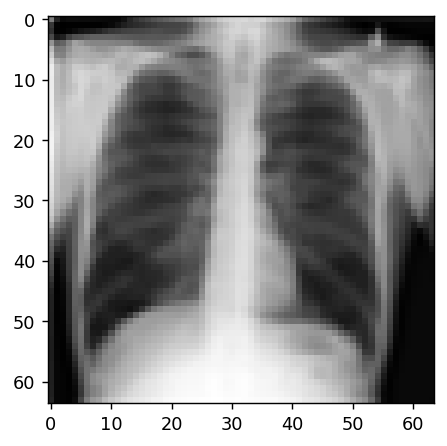

tensor(0)
normal


In [ ]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0][0].numpy()
plt.figure(dpi=128)
plt.imshow(I,cmap='gray')
plt.show()
print(labels[0])
print(tgtnames[labels[0]])

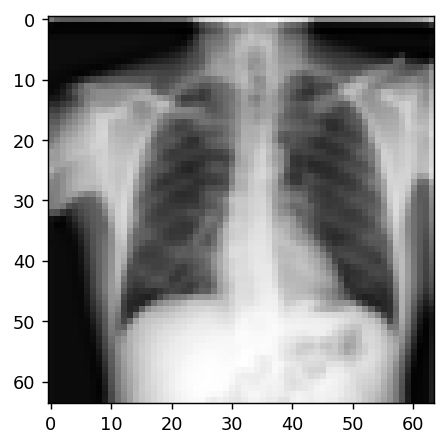

normal


In [ ]:
n=42
I = images[n][0].numpy()
plt.figure(dpi=128)
plt.imshow(I,cmap='gray')
plt.show()
print(tgtnames[labels[n]])

# Model (LeNet-5)

## 개인과제4
- 아래와 같이 정의된 LeNet-5가 있습니다. 
- 네트워크의 구조는 변화시키지 않고(새로운 torch.nn class를 추가하거나 삭제하지 않고), kernel_size, padding, stride, learning rate, num_epochs, loss, alg, batchsize만을 바꾸어가며 학습을 진행하여 validation set에 마지막 epoch에서의 validation accuracy를 최대로 만드는 것이 과제의 목표입니다.

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    Flatten(),
    nn.Linear(in_features=16*14*14, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 2)
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten()
  (7): Linear(in_features=3136, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
# setting hyper-parameters
learning_rate = 10
num_epochs = 10

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

## PyTorch Hub

- PyTorch에서는 resnet, densenet 등 유명한 network를 쉽게 불러와서 활용할 수 있습니다.
- Input은 color image를 기준으로 네트워크 모델이 구현이 되어 있으므로, 1채널 input(흑백영상)을 활용할 때에는 model에 대한 수정이 필요합니다. 여기에서는 input을 넣을 때에 1채널을 동일하게 반복하여 넣는 방식을 사용하였습니다.
- Output의 개수는 class의 개수에 맞게 수정해 주어야 합니다.
- 활용할 수 있는 model을 아래를 참고합니다.
- https://pytorch.org/hub/research-models

In [ ]:
#net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
#print(net)

In [ ]:
#net.fc = nn.Linear(512,2,bias=True)
#net.to(device)
#alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd
#print(net)

# Model Training

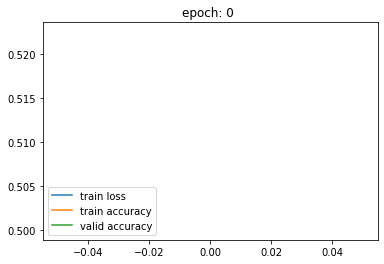

train loss:  nan
train accuracy:  0.5224999785423279
valid accuracy:  0.5


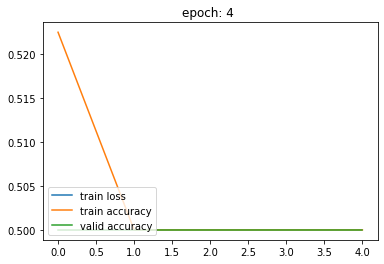

train loss:  nan
train accuracy:  0.5
valid accuracy:  0.5


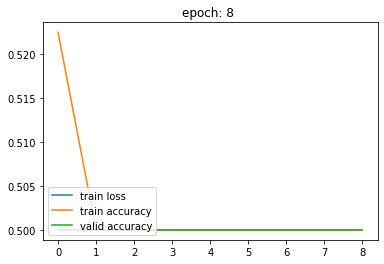

train loss:  nan
train accuracy:  0.5
valid accuracy:  0.5


In [ ]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device)
    y_hat=net(X)
    #y_hat = net(X.repeat(1,3,1,1)) # pytorch hub model
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/len(trainset))

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    #y_hat = net(X.repeat(1,3,1,1))  # pytorch hub model
    correct += (y_hat.argmax(dim=1)==y).sum()

  #print((y_hat[:4]))
  accs_valid = np.append(accs_valid,correct.cpu()/len(validset))


  if epoch%4 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)
    plt.show()

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

## valdiation set results 

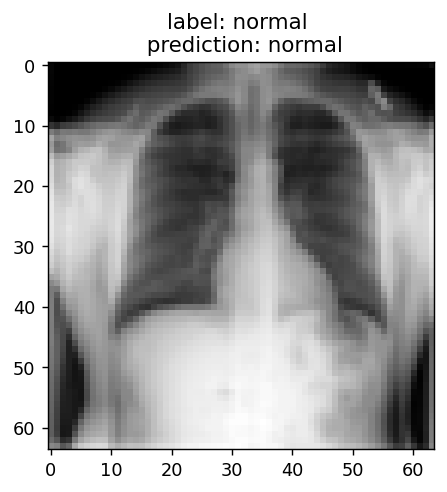

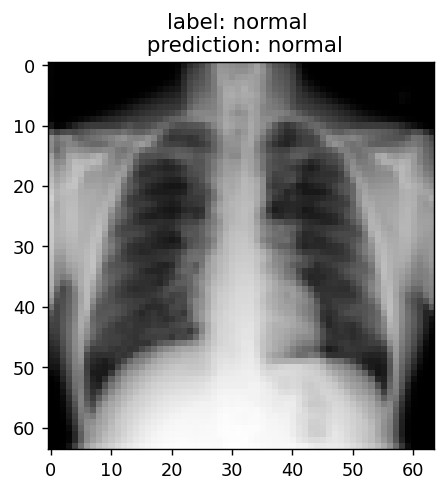

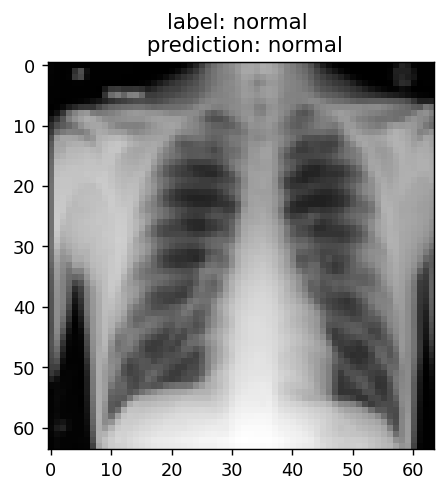

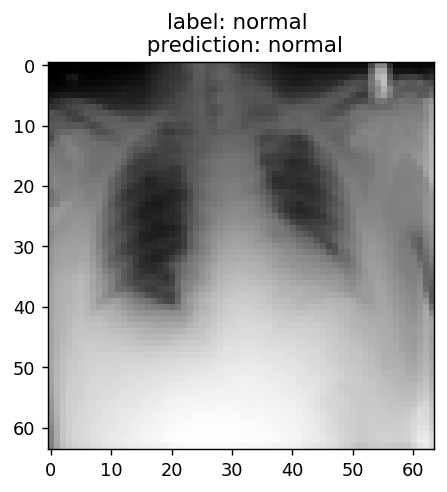

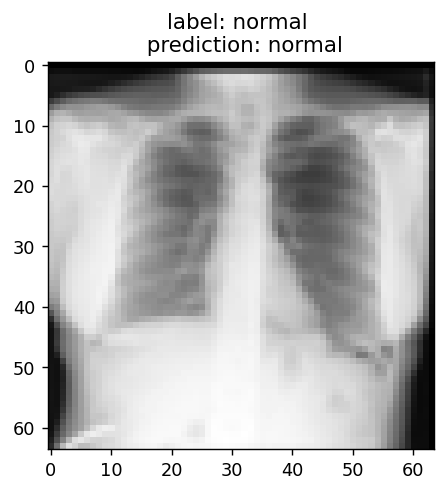

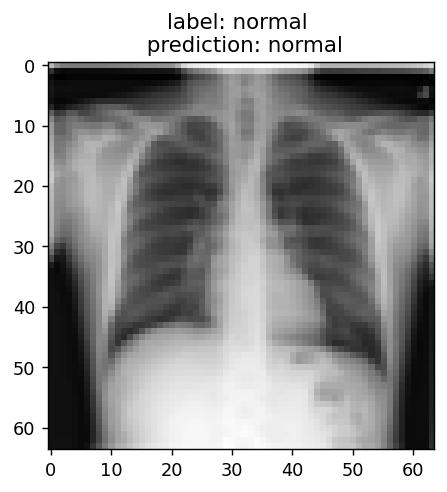

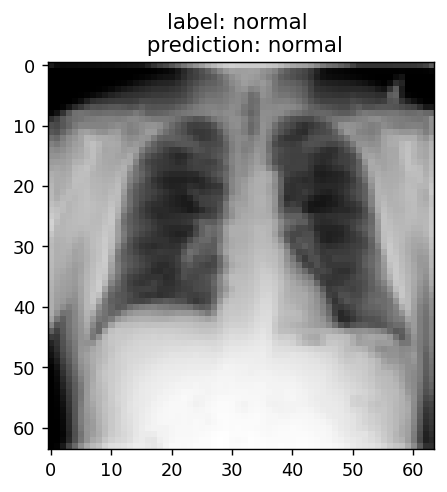

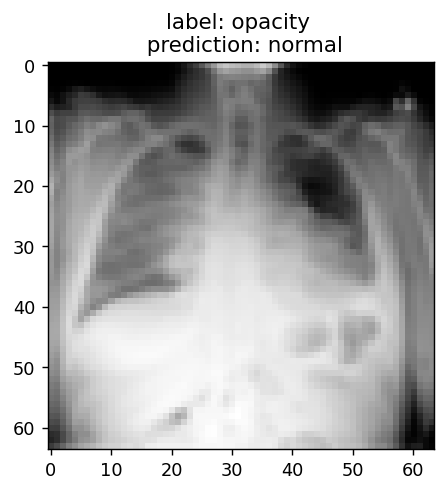

In [ ]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)    
#  y_hat = net(X.repeat(1,3,1,1))  # pytorch hub model
  y_hat = y_hat.argmax(dim=1)
  for n in range(4):
    plt.figure(dpi=128)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
    plt.pause(.0001)
  if i>1:
     break